In [1]:
import os
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
%matplotlib inline
from math import log, exp, pi

# THIS COMMENT IS THE LONGEST A LINE CAN BE AND STILL RENDER COMPLETELY WHEN PRINTING IN LANDSCAPE MODE.
# THIS COMMENT IS 72 CHARACTERS WITHOUT COUNTING THE NEWLINE AT THE END.

# This notebook needs to be able to find the stacked images.

# use named tuples to improve readability

from collections import namedtuple

Point = namedtuple('Point', 'x y')
Extent = namedtuple('Extent', 'width height')
Rectangle = namedtuple('Rectangle', 'center extent')


## Code for Least Squares Fit

In [2]:
def sigma_squared_for_fwhm(fwhm):
    return fwhm**2 / (8 * log(2))

def make_gaussian(fwhm):
    sigma_squared = sigma_squared_for_fwhm(fwhm)
    normalization = 1 / (2 * pi * sigma_squared)
    def gaussian(x, y):
        return normalization * exp(-(x**2 + y**2) / (2 * sigma_squared))
    return gaussian

# The following mess of integers defines the parameter positions in the parameter vector
PINDEX_TARGET_BACKGROUND = 0  # NB: THE TARGET BACKGROUND IS IN ADDITION TO THE GENERAL_BACKGROUND
PINDEX_GENERAL_BACKGROUND = 1
PINDEX_FWHM = 2
POFFSET_BASE = 3  # the number of indices above -- will grow if we further model target background
POFFSET_MULTIPLE = 3  # the number of indices below -- not expected to change
POFFSETINDEX_FLUX = 0
POFFSETINDEX_CENTER_RELATIVE_X = 1  # NB: THIS IS RELATIVE TO THE CENTER OF THE EXTENT
POFFSETINDEX_CENTER_RELATIVE_Y = 2  # NB: THIS IS RELATIVE TO THE CENTER OF THE EXTENT

def roi_model_for_parameters(extent, k, centers, parameters):
    fwhm = parameters[PINDEX_FWHM]
    target_background = parameters[PINDEX_TARGET_BACKGROUND]
    general_background = parameters[PINDEX_GENERAL_BACKGROUND]
    base_index_k = POFFSET_BASE + k * POFFSET_MULTIPLE
    flux = parameters[base_index_k + POFFSETINDEX_FLUX]
    center_relative_x = parameters[base_index_k + POFFSETINDEX_CENTER_RELATIVE_X]
    center_relative_y = parameters[base_index_k + POFFSETINDEX_CENTER_RELATIVE_Y]
    background = target_background + general_background if k == 0 else general_background
    model_roi_data = np.full((extent.height, extent.width), background) # height before width
    gaussian = make_gaussian(fwhm)
    for j in range(extent.height):
        for i in range(extent.width):
            model_roi_data[j, i] += flux * gaussian(
                i - extent.width // 2 - center_relative_x,
                j - extent.height // 2 - center_relative_y
            )
    return model_roi_data

def view_extent_of_data(image_data, center, extent):
    left = center.x - extent.width // 2
    right = left + extent.width
    top = center.y - extent.height // 2
    bottom = top + extent.height
    view = image_data[top:bottom, left:right]
    return view

def make_image_data(width, height, centers, extent, parameters):
    general_background = parameters[PINDEX_GENERAL_BACKGROUND]
    image_data = np.full((height, width), general_background) # height before width in the array shape
    for k in range(len(centers)):
        print('calling roi_model_for_parameters from make_image_data')
        model_roi_data = roi_model_for_parameters(extent, k, centers, parameters)
        view = view_extent_of_data(image_data, centers[k], extent)
        for j in range(extent.height):
            for i in range(extent.width):
                view[j, i] = model_roi_data[j, i]  ## PROBLEM PROBLEM PROBLEM
    return image_data

def roi_residuals(image_data, k, centers, extent, parameters):
    roi_view = view_extent_of_data(image_data, centers[k], extent)
    print('calling roi_model_for_parameters from roi_residuals')
    roi_model = roi_model_for_parameters(extent, k, centers, parameters)
    return roi_view - roi_model

def make_residuals_function(image_data, centers, extent):
    def residuals_function(parameters):
        all_roi_residuals = [
            roi_residuals(image_data, k, centers, extent, parameters)
            for k, center in enumerate(centers)
        ]
        raveled = np.concatenate(all_roi_residuals).ravel()
        print('residuals vector')
        print(raveled)
        return raveled
    
    return residuals_function


## Testing

We test the least squares fitting code above with generated data.

### Generate the Data

In [3]:
# The following are in all caps and prefixed TEST to avoid collisions with the real data.

TEST_DATA_WIDTH = 9
TEST_DATA_HEIGHT = 7

TEST_EXTENT_HALF_WIDTH = 2
TEST_EXTENT_HALF_HEIGHT = TEST_EXTENT_HALF_WIDTH
TEST_EXTENT_WIDTH = 2 * TEST_EXTENT_HALF_WIDTH + 1
TEST_EXTENT_HEIGHT = TEST_EXTENT_WIDTH
TEST_EXTENT = Extent(TEST_EXTENT_WIDTH, TEST_EXTENT_HEIGHT)

TEST_CENTERS = [
    Point(2, 2), # test target
    Point(6, 4), # test reference
]

TEST_CENTER_OFFSETS = [
    Point(-1.0, -1.0), # test target
    Point(0, 1.0), # test reference
]

TEST_TARGET_BACKGROUND = 5.0
TEST_GENERAL_BACKGROUND = 3.0

TEST_FWHM = 2.0

TEST_FLUXES = [
    500.0,
    1000.0
]

TEST_PARAMETERS = [
    TEST_TARGET_BACKGROUND,
    TEST_GENERAL_BACKGROUND,
    TEST_FWHM
]

for k in range(len(TEST_CENTERS)):
    TEST_PARAMETERS.append(TEST_FLUXES[k])
    TEST_PARAMETERS.append(TEST_CENTER_OFFSETS[k].x)
    TEST_PARAMETERS.append(TEST_CENTER_OFFSETS[k].y)

TEST_IMAGE_DATA = make_image_data(
    TEST_DATA_WIDTH, TEST_DATA_HEIGHT,
    TEST_CENTERS,
    TEST_EXTENT,
    TEST_PARAMETERS
)


calling roi_model_for_parameters from make_image_data
calling roi_model_for_parameters from make_image_data


### Display the Test Image

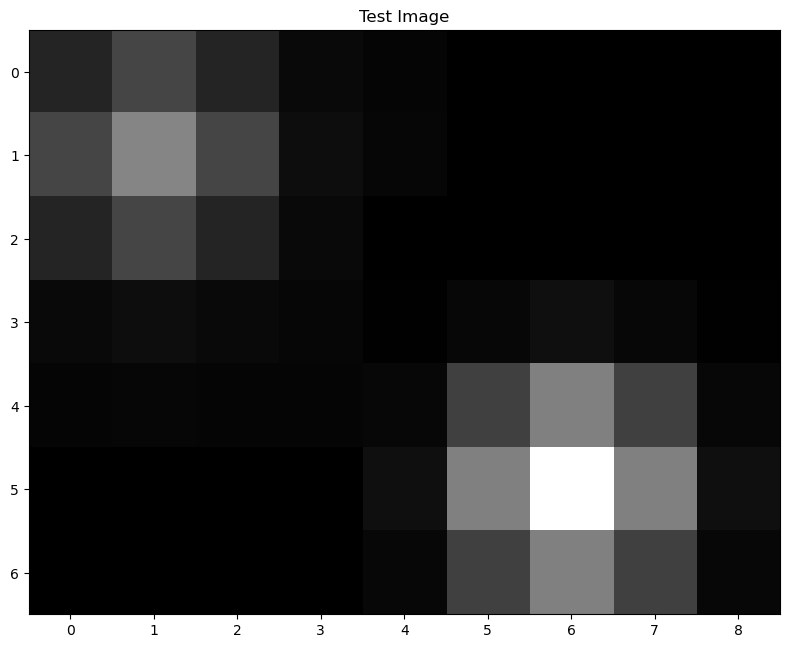

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.imshow(TEST_IMAGE_DATA, cmap='gray')
axes.set_title("Test Image")

plt.tight_layout()
plt.show()


### Fit the Test Image

The routine was doing perfectly with the test data, but I have introduced a bug!!

TODO: We could put Poisson noise into the test data and see how robust the routine is.

In [5]:
# The following are in all caps and prefixed TEST to avoid collisions with the real fit.

TEST_INITIAL_GUESS_FOR_TARGET_BACKGROUND = 4.0
TEST_INITIAL_GUESS_FOR_GENERAL_BACKGROUND = 2.0
TEST_INITIAL_GUESS_FOR_FWHM = 3.0

TEST_INITIAL_PARAMETER_VECTOR = [
    TEST_INITIAL_GUESS_FOR_TARGET_BACKGROUND,
    TEST_INITIAL_GUESS_FOR_GENERAL_BACKGROUND,
    TEST_INITIAL_GUESS_FOR_FWHM
]

for _ in range(len(TEST_CENTERS)):
    TEST_INITIAL_PARAMETER_VECTOR.append(10.0)  # Initial guess for flux
    TEST_INITIAL_PARAMETER_VECTOR.append(0.0)   # Initial guess for center_relative_x
    TEST_INITIAL_PARAMETER_VECTOR.append(0.0)   # Initial guess for center_relative_y
    
TEST_RESIDUALS_FUNCTION = make_residuals_function(TEST_IMAGE_DATA, TEST_CENTERS, TEST_EXTENT)

TEST_RESIDUALS_FUNCTION(TEST_INITIAL_PARAMETER_VECTOR)

calling roi_model_for_parameters from roi_residuals
calling roi_model_for_parameters from roi_residuals
residuals vector
[ 29.49605038  56.9487461   29.29347465   5.23727732   2.02433258
  56.9487461  111.78824535  56.43828726   8.36530777   2.00531052
  29.29347465  56.43828726  28.59884735   4.72681847  -3.25904232
   5.23727732   8.36530777   4.72681847   1.90137418  -2.34829612
   2.02433258   2.00531052   1.82175685   1.80331259   3.81146286
   0.94353341   1.00531052   1.14495353   1.00531052   0.94353341
   1.65170388   7.36530777  14.06911223   7.36530777   1.65170388
   7.60888713  55.43828726 110.33719741  55.43828726   7.60888713
  14.57957108 110.78824535 220.91498737 110.78824535  14.57957108
   7.81146286  55.9487461  111.0318247   55.9487461    7.81146286]


array([ 29.49605038,  56.9487461 ,  29.29347465,   5.23727732,
         2.02433258,  56.9487461 , 111.78824535,  56.43828726,
         8.36530777,   2.00531052,  29.29347465,  56.43828726,
        28.59884735,   4.72681847,  -3.25904232,   5.23727732,
         8.36530777,   4.72681847,   1.90137418,  -2.34829612,
         2.02433258,   2.00531052,   1.82175685,   1.80331259,
         3.81146286,   0.94353341,   1.00531052,   1.14495353,
         1.00531052,   0.94353341,   1.65170388,   7.36530777,
        14.06911223,   7.36530777,   1.65170388,   7.60888713,
        55.43828726, 110.33719741,  55.43828726,   7.60888713,
        14.57957108, 110.78824535, 220.91498737, 110.78824535,
        14.57957108,   7.81146286,  55.9487461 , 111.0318247 ,
        55.9487461 ,   7.81146286])

In [9]:
TEST_BOUNDS = [
    [
        0.0,
        0.0,
        1.0,
        0.0,
        -TEST_EXTENT_HALF_WIDTH,
        -TEST_EXTENT_HALF_HEIGHT,
        0.0,
        -TEST_EXTENT_HALF_WIDTH,
        -TEST_EXTENT_HALF_HEIGHT
    ],[
        np.inf,
        np.inf,
        15.0,
        np.inf,
        TEST_EXTENT_HALF_WIDTH,
        TEST_EXTENT_HALF_HEIGHT,
        np.inf,
        TEST_EXTENT_HALF_WIDTH,
        TEST_EXTENT_HALF_HEIGHT
    ]
]

TEST_RESULT = least_squares(TEST_RESIDUALS_FUNCTION, np.array(TEST_INITIAL_PARAMETER_VECTOR), bounds=TEST_BOUNDS)

TEST_RESULT.x

# TEST_IMAGE_DATA[140:161, 40:61]

calling roi_model_for_parameters from roi_residuals
calling roi_model_for_parameters from roi_residuals
residuals vector
[ 29.49605038  56.9487461   29.29347465   5.23727732   2.02433258
  56.9487461  111.78824535  56.43828726   8.36530777   2.00531052
  29.29347465  56.43828726  28.59884735   4.72681847  -3.25904232
   5.23727732   8.36530777   4.72681847   1.90137418  -2.34829612
   2.02433258   2.00531052   1.82175685   1.80331259   3.81146286
   0.94353341   1.00531052   1.14495353   1.00531052   0.94353341
   1.65170388   7.36530777  14.06911223   7.36530777   1.65170388
   7.60888713  55.43828726 110.33719741  55.43828726   7.60888713
  14.57957108 110.78824535 220.91498737 110.78824535  14.57957108
   7.81146286  55.9487461  111.0318247   55.9487461    7.81146286]
calling roi_model_for_parameters from roi_residuals
calling roi_model_for_parameters from roi_residuals
residuals vector
[ 29.49605032  56.94874604  29.29347459   5.23727726   2.02433252
  56.94874604 111.78824529  56.

array([ 4.61077098e+00,  2.92082004e+00,  2.00312129e+00,  5.04813109e+02,
       -9.99243967e-01, -9.99154135e-01,  1.00231210e+03,  5.04934742e-12,
        1.00000188e+00])